In [55]:
%load_ext autoreload
%autoreload

import time
import sys
import os
py_script = "/Users/jbrown/OneDrive - Queen's University Belfast/python_scripts"
if py_script is not sys.path:
    sys.path.append(py_script)

from SB_StirapEnvironments import  StepEnv, ContinuousEnv, DiscreteEnv
import numpy as np
import tensorflow as tf
import stable_baselines
from stable_baselines.common.policies import MlpPolicy, FeedForwardPolicy, MlpLnLstmPolicy
from stable_baselines.deepq import LnMlpPolicy as DQNmlp
from stable_baselines import PPO1, DQN, PPO2, TD3, A2C
from stable_baselines.common.callbacks import EvalCallback
from stable_baselines.bench import Monitor
import matplotlib.pyplot as plt
%matplotlib inline

from Miscellany import CtapPlot, PlottingCallback
from stable_baselines.common.env_checker import check_env
from stable_baselines.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines.common import set_global_seeds

from stable_baselines.common.cmd_util import make_vec_env
from stable_baselines.common.evaluation import evaluate_policy

from collections import deque

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Define the number of timesteps in the evolution
steps=200
# Define the number of randomly sampled unitaries to use at each timestep
num_runs=100
# generate the initial state
rho=np.zeros(9)
rho[0]=1
rho_in = rho
# Diagonal Initial State
rho_in_diag = np.array([rho_in[0],rho_in[4],rho_in[8]])

# Function that carries out one step of the evolution by randomly sampling the Hamiltonians for use 
# in the QuTiP solver
def get_1_step(rho, timestep):
    global omega12, omega23
    tlist = [0,timestep]
    rho_out = np.zeros((num_runs,3,3))
    average_rho_out = np.zeros((3,3))
    for i in range(num_runs):
        delta1 = np.random.uniform(0,omega12*0.15)
        delta2 = np.random.uniform(0,omega12*0.15)
        H=qt.Qobj(np.array([[0,-omega12,0],
                        [-omega12, delta1, -omega23],
                        [0, -omega23, delta2]]))
        
        output = qt.mesolve(H, qt.Qobj(rho.reshape(3,3)), tlist)
        
        rho_out[i]=output.states[-1].full()
    
    average_rho_out = np.average(rho_out, axis=0)
    rho_final = average_rho_out.flatten()
    rho_diag = average_rho_out.diagonal().flatten()
    return rho_final, rho_diag
# for plotting
full_obs_vec = np.zeros((steps,9))
diag_obs_vec = np.zeros((steps,3))

for step in range(steps):
    omega12=10
    omega23=10
    full_obs_vec[step,:] = rho_in
    diag_obs_vec[step,:] = rho_in_diag
    rho, rho_in_diag = get_1_step(rho_in, 0.0025)
    rho_in = rho
    
plt.plot(range(steps),full_obs_vec[:,0], label=0)
plt.plot(range(steps),full_obs_vec[:,4], label = 1)
plt.plot(range(steps),full_obs_vec[:,8], label=2)
plt.legend()



NameError: name 'qt' is not defined

/Users/jbrown/opt/anaconda3/envs/stablebase/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Loading a model without an environment, this model cannot be trained until it has a valid environment.
Maximum final population: 0.5141529857636259  
Max middle population: 0.7702950506850843


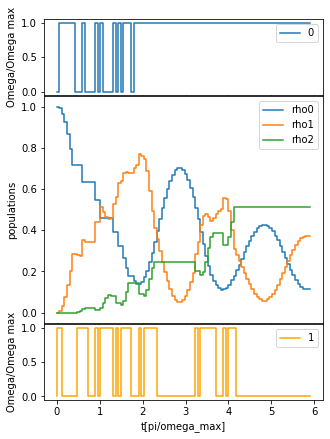

In [76]:
ctapplot = CtapPlot()
env = DiscreteEnv(num_levels=3, max_time=100, omega_max=75, discreteness=2, 
                  observation_verbosity = 4, timestep=0.0025, detuning=True, detuning_fixed=True,
                 detuning_percent=0.15)




best_model = DQN.load("/Users/jbrown/OneDrive - Queen's University Belfast/python_scripts/Saved_Models/DDQN/best_model")
ctapplot.discrete_plots(env=env, model=best_model, num_timesteps=100)

